In [1]:
library(monocle3)
library(dplyr)
library(Seurat)
library(SeuratWrappers)
library(ggplot2)
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(dplyr)
library(ggplot2)
library(patchwork)

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading

In [2]:
# Read expression matrix, metadata, and gene metadata
expression_matrix <- read.csv('Monocle3_folder/expression_matrix.csv', row.names = 1)
metadata <- read.csv('Monocle3_folder/metadata.csv', row.names = 1)
gene_metadata <- read.csv('Monocle3_folder/gene_metadata.csv', row.names = 1)

expression_matrix <- t(expression_matrix)
rownames(expression_matrix) <- rownames(gene_metadata)
colnames(expression_matrix) <- rownames(metadata)
gene_metadata$gene_short_name = rownames(gene_metadata)

# Create a CellDataSet object
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = metadata,
                         gene_metadata = gene_metadata)

# Read embedding and UMAP values
fuse_embed <- read.csv('Monocle3_folder/ssgate_embed.csv', row.names = 1)
umap <- read.csv('Monocle3_folder/umap.csv', row.names = 1)
fuse_embed <- as.matrix(fuse_embed)
umap <- as.matrix(umap)

In [3]:
# Preprocess the CellDataSet with PCA and integrate existing embeddings
cds <- preprocess_cds(cds, num_dim = 30, method = "PCA")
reducedDims(cds)$PCA <- fuse_embed
cds <- reduce_dimension(cds, reduction_method ='UMAP')
reducedDims(cds)$UMAP <- umap

Warning message in .check_reddim_names(x, value[[v]], withDimnames = TRUE, vname = sprintf("value[[%s]]", :
“non-NULL 'rownames(value[[1]])' should be the same as 'colnames(x)' for
'reducedDims<-'. This will be an error in the next release of
Bioconductor.”
No preprocess_method specified, using preprocess_method = 'PCA'

Warning message in .check_reddim_names(x, value[[v]], withDimnames = TRUE, vname = sprintf("value[[%s]]", :
“non-NULL 'rownames(value[[2]])' should be the same as 'colnames(x)' for
'reducedDims<-'. This will be an error in the next release of
Bioconductor.”


In [8]:
# Convert cell type information to character and add color
colData(cds)$ssgate_cluster <- as.character(colData(cds)$ssgate_cluster)
unique_cell_types <- sort(unique(colData(cds)$ssgate_cluster))
colors <- c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8C564B', '#8c564b')
color_mapping <- setNames(colors, unique_cell_types)
colData(cds)$color <- color_mapping[colData(cds)$ssgate_cluster]

In [10]:
# Assign the color information to a new column and perform clustering and graph learning
colData(cds)$color_cells <- colData(cds)$color
cds <- cluster_cells(cds)
cds <- learn_graph(cds)

Save the processed CellDataSet object to a file
saveRDS(cds, file = "Monocle_result/sce_SCS_MT.rds")

  |======================================================================| 100%


In [ ]:
# Load the saved SingleCellExperiment object
sce <- readRDS("Monocle_result/sce_SCS_MT.rds")
cds <- sce

png 
  2

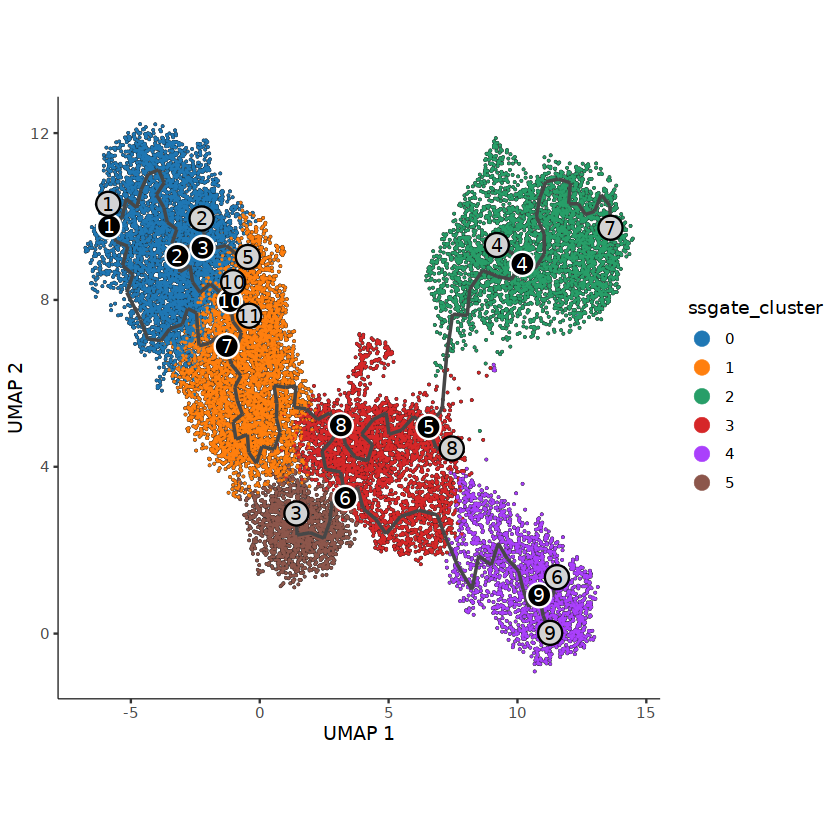

In [11]:
# Generate a cell plot and save as PNG
p <- plot_cells(cds,
           color_cells_by = "ssgate_cluster",
           label_cell_groups=FALSE,
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=4) + scale_color_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8C564B', '#8c564b'))
p <- p + theme(
  aspect.ratio = 1, 
  plot.margin = margin(5, 5, 5, 5)  
)
print(p)
ggsave("Monocle3_SCS_MT.png", plot = p, width = 8, height = 8)


# Generate a PDF version of the plot
pdf("Monocle3_SCS_MT.pdf")
plot_cells(cds,
           color_cells_by = "ssgate_cluster",
           label_cell_groups=FALSE,
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5) + scale_color_manual(values = c('#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8C564B', '#8c564b'))
dev.off()

In [13]:
# Make a co-expression module
# Define a function to find the root node for each cell type and draw a graph based on the root_node

get_earliest_principal_node <- function(cds, celltype ="0"){
  cell_ids <- which(colData(cds)[, "celltype_SSMI_DGATE_leiden"] == celltype)
  closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]
  root_pr_nodes
}

# Define the cell types to be processed
cell_types <- as.character(0:5)
plots <- list()

# Generate and save pseudotime plots for each cell type
for (cell_type in cell_types) {
  # Calculate pseudo time
  cds <- order_cells(cds, root_pr_nodes = get_earliest_principal_node(cds, celltype = cell_type))
  
  # Generate graphics
  p <- plot_cells(cds,
                  color_cells_by = "pseudotime",
                  label_cell_groups = FALSE,
                  label_leaves = FALSE,
                  label_branch_points = FALSE,
                  graph_label_size = 5) + 
      ggtitle(paste("Cell Type", cell_type))
  
  # Save the graph to a list
  plots[[cell_type]] <- p
}

# stitch all the images together
combined_plot <- plot_grid(plotlist = plots, ncol = 2)

# Save the stitched graphics
ggsave("Monocle3_SCS_MT_pseudotime_combined.png", plot = combined_plot, width = 16, height = 24)

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 23301 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 42699 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values

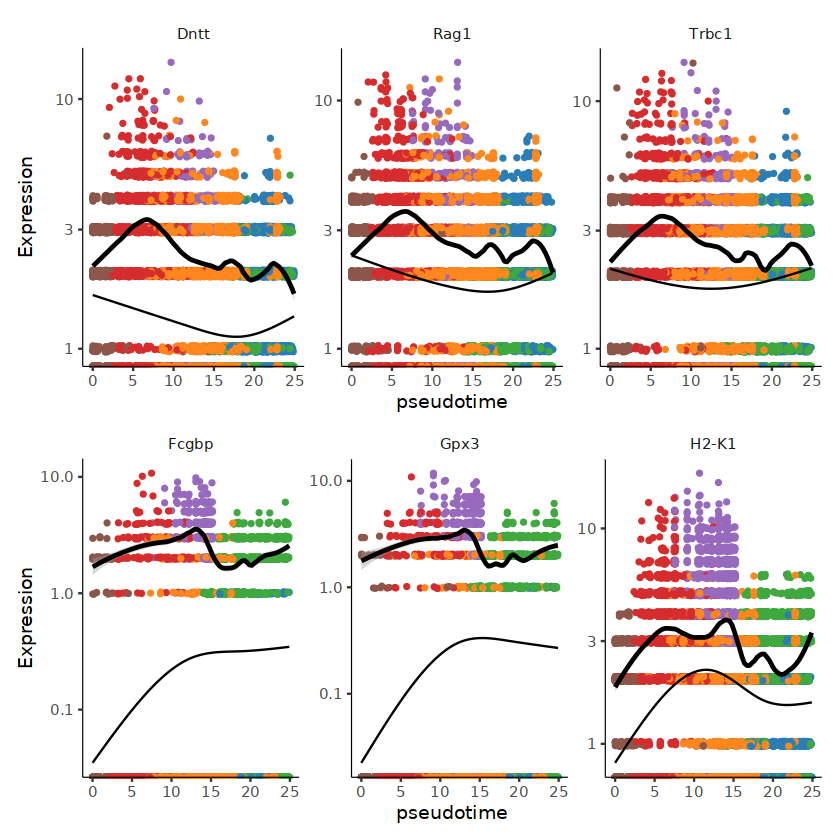

In [14]:
# Define gene groups for pseudotime analysis
genes_group1 <- c("Dntt", "Rag1", "Trbc1")
genes_group2 <- c("Fcgbp", "Gpx3", "H2-K1")


# Function to plot genes in pseudotime
# library(Monocle3)  # Load Monocle3 or relevant package for pseudotime analysis
library(ggplot2)
library(patchwork)  # For combining plots

plot_genes_group <- function(genes, cds, color_scheme) {
  valid_genes <- genes[genes %in% rownames(rowData(cds))]
  p <- plot_genes_in_pseudotime(cds[valid_genes, ],
                                color_cells_by = "ssgate_cluster",
                                min_expr = 0,
                                cell_size = 1,
                                ncol = 3) +
        scale_color_manual(values = color_scheme) +
        geom_smooth(method = "loess", span = 0.3, color = "black") +
        guides(colour = FALSE)  # Hide individual plot legends
  return(p)
}
# Define a color scheme for the plots
color_scheme <- c('#2A7DB7', '#FF871E', '#3FA83F', '#D72C2D', '#976ABE', '#8C564B', '#E37AC2')

# Generate plots for each gene group
plot1 <- plot_genes_group(genes_group1, cds, color_scheme)
plot2 <- plot_genes_group(genes_group2, cds, color_scheme)

# Combine plots and collect guides
combined_plot <- plot1 / plot2 + plot_layout(guides = 'collect')  # Ensures only one legend
print(combined_plot)  # Display the plot
# Save the combined plot as a PNG file with specified dimensions
ggsave("combined_genes_plot_SCS_MT.png", plot = combined_plot, width = 9, height = 6)
